In [1]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

### 1. Get Enrichr counts

In [2]:
# Make counts
count_dataframe = pd.read_feather('./feather.dir/list_off_co.feather').set_index('gene_symbol')

# Get counts
gene_count_dataframe = pd.Series(np.diag(count_dataframe), index=count_dataframe.index, name='counts').to_frame()
gene_count_dataframe.head()

/Users/denis/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead



counts
gene_symbol        
A1BGAS1         821
A1CF           2776
A2M            8431
A2ML1          2677
A2MP1           324

### 2. Get ARCHS4 Expression

In [ ]:
# Read ARCHS4 HDF5
infile = '/Users/denis/Documents/Projects/jupyter-notebook/notebook-generator/database/data/archs4/rawdata.dir/v6/human_matrix.h5'
r = h5py.File(infile, 'r')

# Get matrix data
expr = r['data']['expression'].value
genes = r['meta']['genes'].value.astype(str)

# Submitted genes
genes_idx = [i for i, gene in enumerate(genes) if gene in gene_count_dataframe.index]

In [103]:
archs_matrix = expr[:5000, genes_idx]
archs_matrix_norm = (archs_matrix.T/archs_matrix.sum(axis=1)).T*10**6

In [104]:
# Get mean
mean_dataframe = pd.Series(data=np.mean(archs_matrix_norm, axis=0), index=genes[genes_idx]).rename('average_counts').to_frame()
mean_dataframe.head()

average_counts
A1CF           9.495048
A2M          338.185086
A2ML1         11.955415
A2MP1          1.695327
A3GALT2        0.126733

### 3. Get gene biotype

In [105]:
biotype_dataframe = pd.read_table('./rawdata.dir/gene_biotypes.txt', index_col='Gene name').rename(columns={'Gene type': 'gene_type'})
biotype_dataframe.head()

gene_type
Gene name           
MIR4723        miRNA
RF00019     misc_RNA
RF02116     misc_RNA
MIR6085        miRNA
RNU6-1328P     snRNA

### 4. Merge

In [106]:
# Merge
print(gene_count_dataframe.shape)
print(mean_dataframe.shape)
print(biotype_dataframe.shape)
plot_dataframe = gene_count_dataframe.merge(mean_dataframe, left_index=True, right_index=True).merge(biotype_dataframe, left_index=True, right_index=True)
plot_dataframe['pseudogene'] = ['pseudogene' in x for x in plot_dataframe['gene_type']]
print(plot_dataframe.shape)
plot_dataframe.head()

(23568, 1)
(17933, 1)
(64914, 1)
(20244, 4)


counts  average_counts                           gene_type  \
A1CF       2776        9.495048                      protein_coding   
A2M        8431      338.185086                      protein_coding   
A2ML1      2677       11.955415                      protein_coding   
A2MP1       324        1.695327  transcribed_unprocessed_pseudogene   
A3GALT2    1322        0.126733                      protein_coding   

         pseudogene  
A1CF          False  
A2M           False  
A2ML1         False  
A2MP1          True  
A3GALT2       False

#### 5. Plot

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



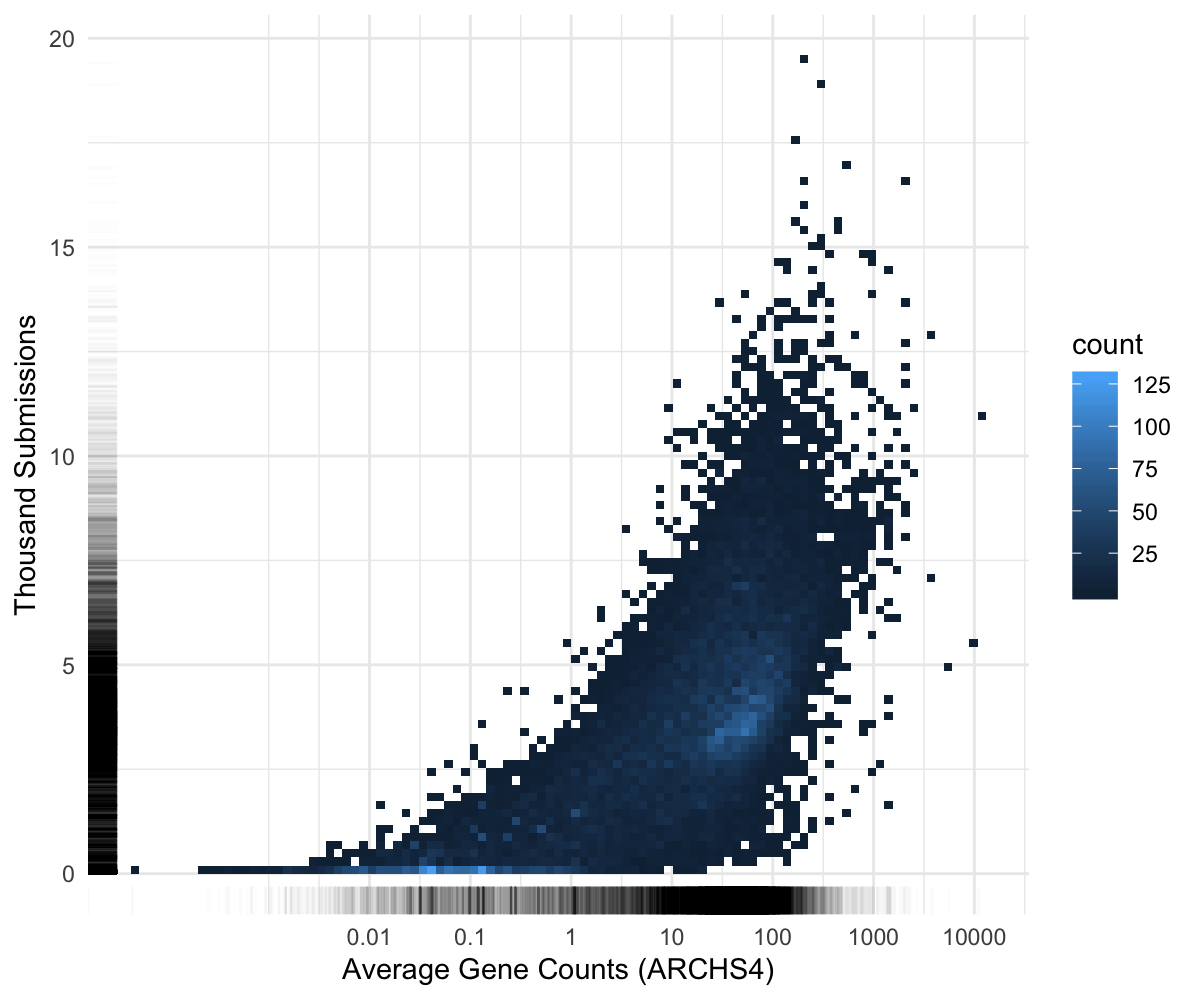

In [107]:
%%R -i plot_dataframe -h 1000 -w 1200 -r 190
xticks <- 10^seq(-2,5,by=1)
ggplot(plot_dataframe, aes(x=average_counts, y=counts/1000)) +
#     geom_point() + 
    geom_bin2d(bins=100) +
    geom_rug(alpha=0.01, color='black') + 
    scale_x_log10(breaks=xticks, labels=xticks) + 
    theme_minimal() +
    ylab('Thousand Submissions') +
    xlab('Average Gene Counts (ARCHS4)')
#     ggtitle('Average gene expression vs Enrichr submissions')

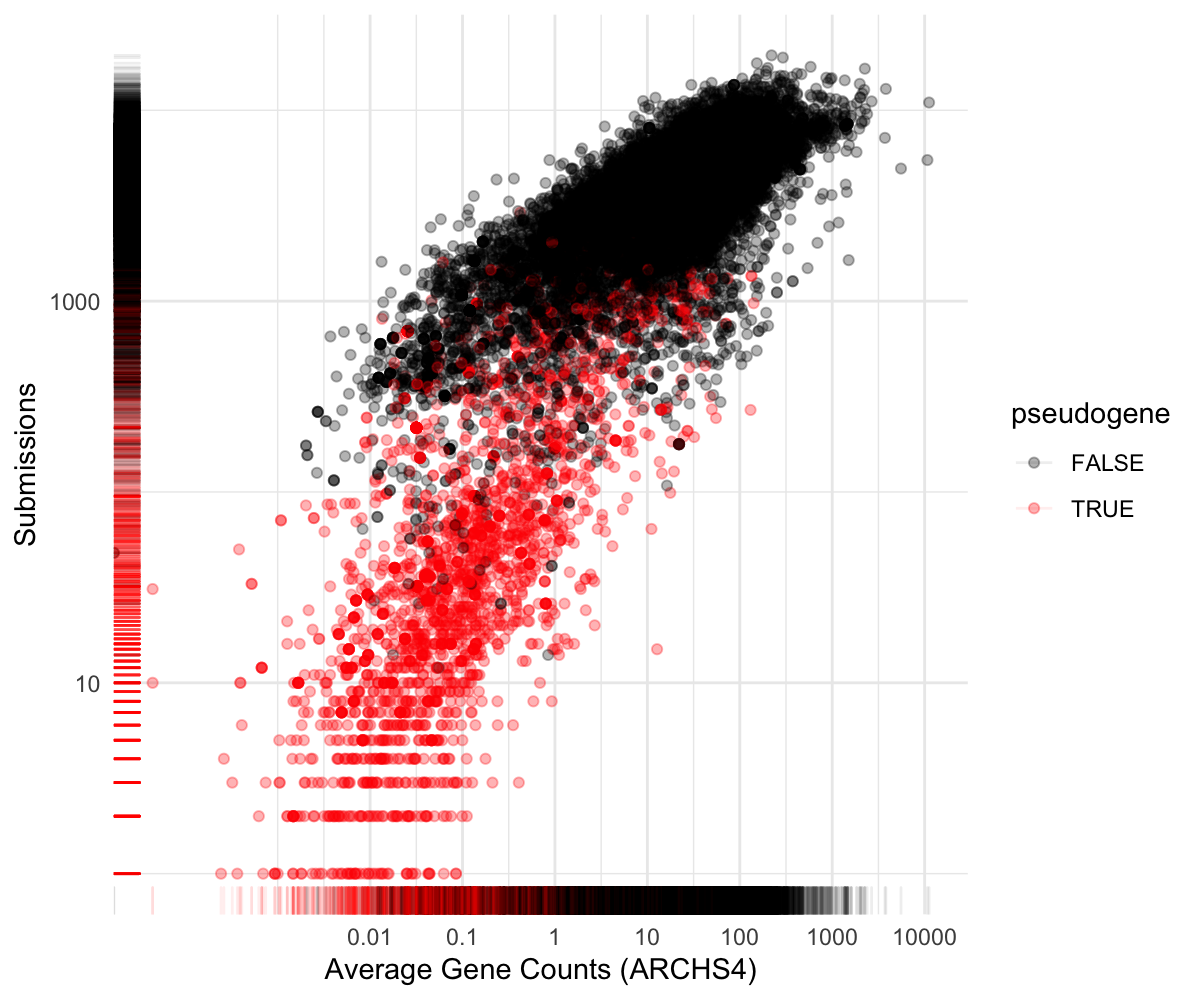

In [108]:
%%R -i plot_dataframe -h 1000 -w 1200 -r 190
xticks <- 10^seq(-2,5,by=1)
ggplot(plot_dataframe, aes(x=average_counts, y=counts, color=pseudogene)) +
    geom_point(alpha=0.3) + 
#     geom_bin2d(bins=100) +
    scale_color_manual(values=c('black', 'red')) +
    geom_rug(alpha=0.07) + 
    scale_x_log10(breaks=xticks, labels=xticks) + 
    scale_y_log10() + 
    theme_minimal() +
    ylab('Submissions') +
    xlab('Average Gene Counts (ARCHS4)')
#     ggtitle('Average gene expression vs Enrichr submissions')

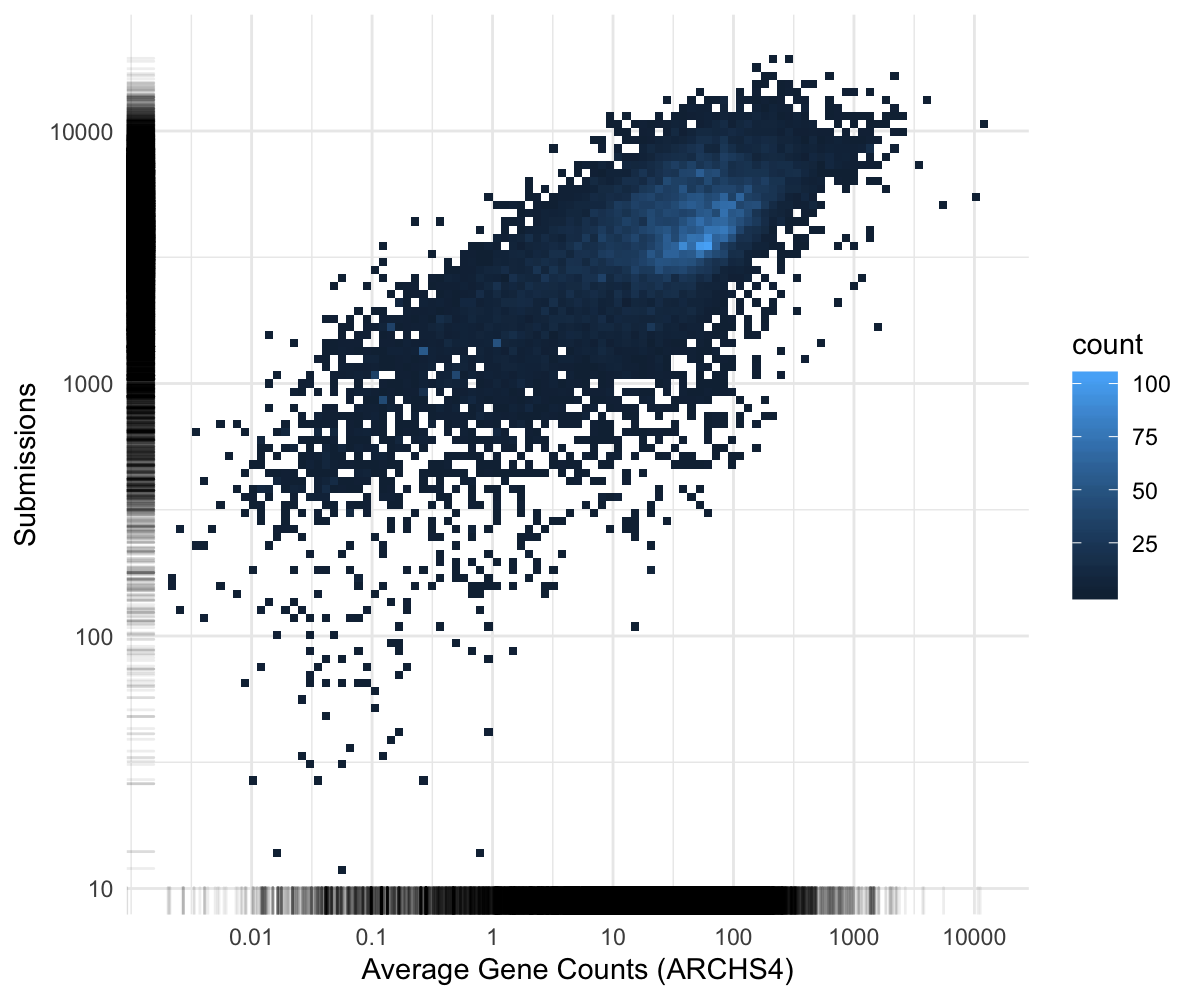

In [109]:
%%R -i plot_dataframe -h 1000 -w 1200 -r 190
xticks <- 10^seq(-2,5,by=1)
plot_dataframe <- plot_dataframe[plot_dataframe$pseudogene == FALSE,]
ggplot(plot_dataframe, aes(x=average_counts, y=counts)) +
#     geom_point(alpha=0.3) + 
    geom_bin2d(bins=100) +
    geom_rug(alpha=0.07) + 
    scale_x_log10(breaks=xticks, labels=xticks) + 
    scale_y_log10(breaks=xticks, labels=xticks) + 
    theme_minimal() +
    ylab('Submissions') +
    xlab('Average Expression (ARCHS4)')
#     ggtitle('Average gene expression vs Enrichr submissions')

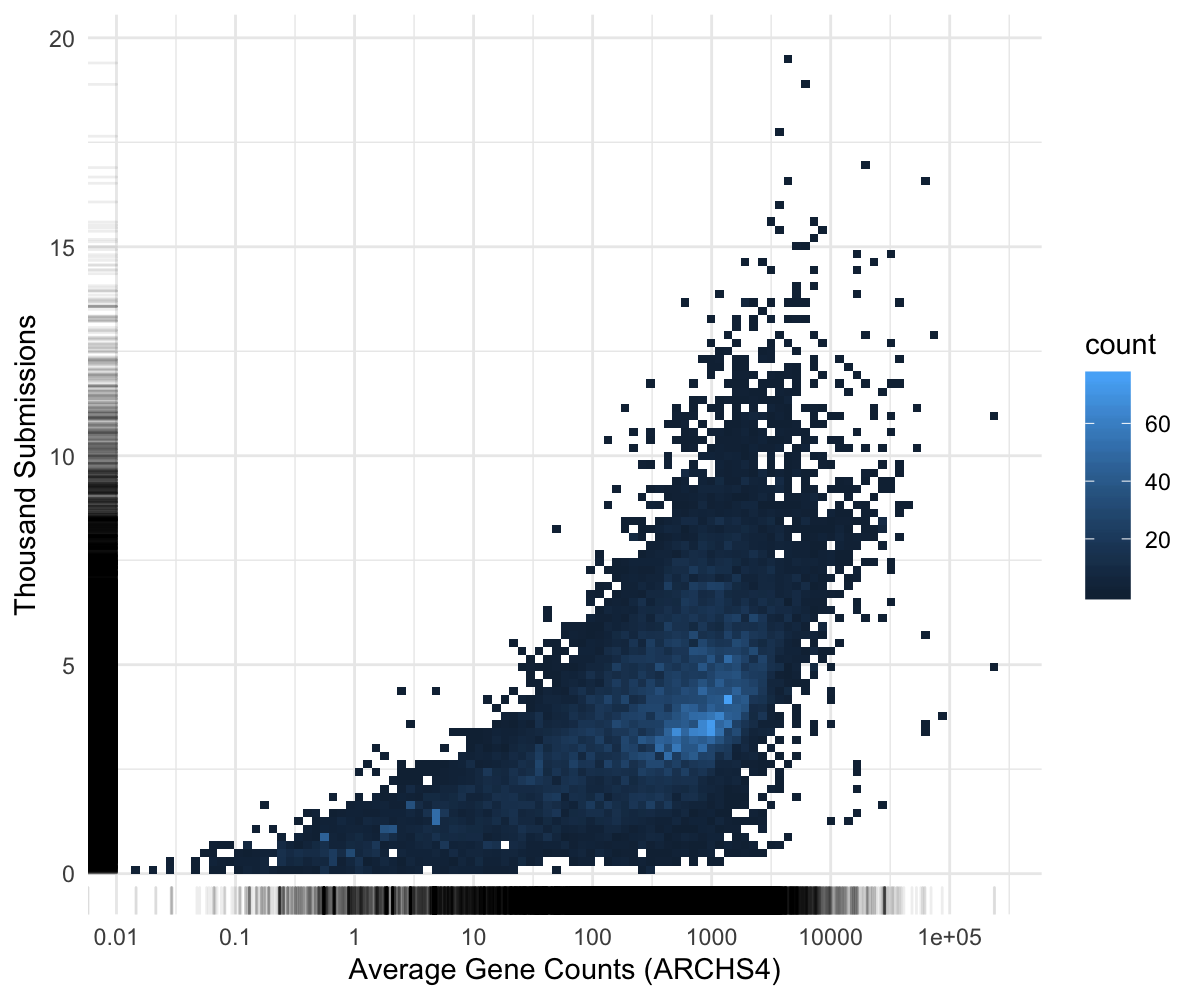

In [92]:
%%R -i plot_dataframe -h 1000 -w 1200 -r 190
xticks <- 10^seq(-2,5,by=1)
plot_dataframe <- plot_dataframe[plot_dataframe$pseudogene == FALSE,]
ggplot(plot_dataframe, aes(x=average_counts, y=counts/1000)) +
#     geom_point(alpha=0.3) + 
    geom_bin2d(bins=100) +
    geom_rug(alpha=0.07) + 
    scale_x_log10(breaks=xticks, labels=xticks) + 
#     scale_y_log10() + 
    theme_minimal() +
    ylab('Thousand Submissions') +
    xlab('Average Gene Counts (ARCHS4)')
#     ggtitle('Average gene expression vs Enrichr submissions')